Importing libraries for the program. Pandas for data processing, matplotlib for plotting graphs, KMeans to do the clustering and scores to find the scores.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

Have imported warnings and muted as they were just a pain while training the KMeans

In [6]:
import warnings
warnings.filterwarnings('ignore')

The dataset is taken from UCI ML Repo

In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
column_names = ["ID", "Diagnosis"] + [f"Feature_{i}" for i in range(1,31)]
data = pd.read_csv(url, header=None, names=column_names)

Dropping ID and Diagnosis as they aren't necessary for clustering

In [8]:
data.drop(["ID", "Diagnosis"], axis=1, inplace=True)
features = data.columns.to_list()

Have made different functions for different types of windows

In [9]:
def windowing_sliding(window_size):
    windows = [data.iloc[i:i+window_size] for i in range(0, len(data)-window_size+1)]
    return windows

In [10]:
def windowing_tumbling(window_size):
    windows = [data.iloc[i:i+window_size] for i in range(0, len(data), window_size)]
    return windows

In [11]:
def windowing_hopping(window_size, overlap=0.5):
    hop_size = int(window_size * (1 - overlap))
    windows = [data.iloc[i:i+window_size] for i in range(0, len(data)-window_size+1, hop_size)]
    return windows

In [12]:
def windowing_exponential_decay(alpha=0.1):
    windows = []
    current_size = len(data)
    while current_size > 0:
        windows.append(data.tail(current_size))
        current_size = int(alpha * current_size)
        return windows

A clustering function which does clustering for each window

In [13]:
def perform_clustering(window, n_clusters):
    kmeans = KMeans(n_clusters = n_clusters, random_state=100)
    window["Cluster_Labels"] = kmeans.fit_predict(window[features])
    return window

All the clusters are evaluted and the scores are appended in the metrics list

In [14]:
def evaluate_clustering_scores(windows, clustering_metrics, window_info):
    for window in windows:
        window_result = perform_clustering(window, n_clusters=5)
        features = window_result.drop(["Cluster_Labels"], axis=1)
        labels = window_result["Cluster_Labels"]
        silhouette = silhouette_score(features, labels)
        davies_bouldin = davies_bouldin_score(features, labels)
        calinski_harabasz = calinski_harabasz_score(features, labels)
        clustering_metrics.append({"Window_Info": window_info, "Silhouette_Score": silhouette, "Davies_Bouldin_Index": davies_bouldin, "Calinski_Harabasz_Index": calinski_harabasz})

Time to plot the graphs

In [15]:
def plot_clustering_metrics(df):
    plt.figure(figsize=(25, 20))
    def silhouette_score_plot():
        # Plot Silhouette Score
        plt.subplot(3, 1, 1)
        for window_info, group in df.groupby("Window_Info"):
            plt.plot(group.index, group["Silhouette_Score"],
            label=f"{window_info}")
            plt.xlabel("Window Index")
            plt.ylabel("Silhouette Score")
            plt.legend(title="Windowing Technique")
            plt.title("Silhouette Score")

    def db_index_plot():   
        # Plot Davies-Bouldin Index
        plt.subplot(3, 1, 2)
        for window_info, group in df.groupby("Window_Info"):
            plt.plot(group.index, group["Davies_Bouldin_Index"],
            label=f"{window_info}")
            plt.xlabel("Window Index")
            plt.ylabel("Davies-Bouldin Index")
            plt.legend(title="Windowing Technique")
            plt.title("Davies-Bouldin Index")

    def ch_index_plot():
        # Plot Calinski-Harabasz Index
        plt.subplot(3, 1, 3)
        for window_info, group in df.groupby("Window_Info"):
            plt.plot(group.index, group["Calinski_Harabasz_Index"],
            label=f"{window_info}")
            plt.xlabel("Window Index")
            plt.ylabel("Calinski-Harabasz Index")
            plt.legend(title="Windowing Technique")
            plt.title("Calinski-Harabasz Index")
            plt.tight_layout()
            plt.show()    
    silhouette_score_plot()
    db_index_plot()
    ch_index_plot()

In [16]:
window_sizes = [10, 15, 20, 25]
overlap_ratio = 0.5
alpha_decay = 0.15
clustering_metrics = []

Running the evaluation for each window of different sizes

In [17]:
for window_size in window_sizes:
    # Sliding Window
    windows = windowing_sliding(window_size)
    evaluate_clustering_scores(windows, clustering_metrics, f'Sliding Window with window size : {window_size}')
    # Tumbling Window
    windows = windowing_tumbling(window_size)
    evaluate_clustering_scores(windows, clustering_metrics, f'Tumbling Window with window size : {window_size}')
    # Hopping Window
    windows = windowing_hopping(window_size, overlap=overlap_ratio)
    evaluate_clustering_scores(windows, clustering_metrics, f'Hopping Window with window size : {window_size}')
    # Exponential Decaying Window
    windows = windowing_exponential_decay(alpha=alpha_decay)
    evaluate_clustering_scores(windows, clustering_metrics, "Exponential Decay")

Let us call the plot function to actually see some graphs

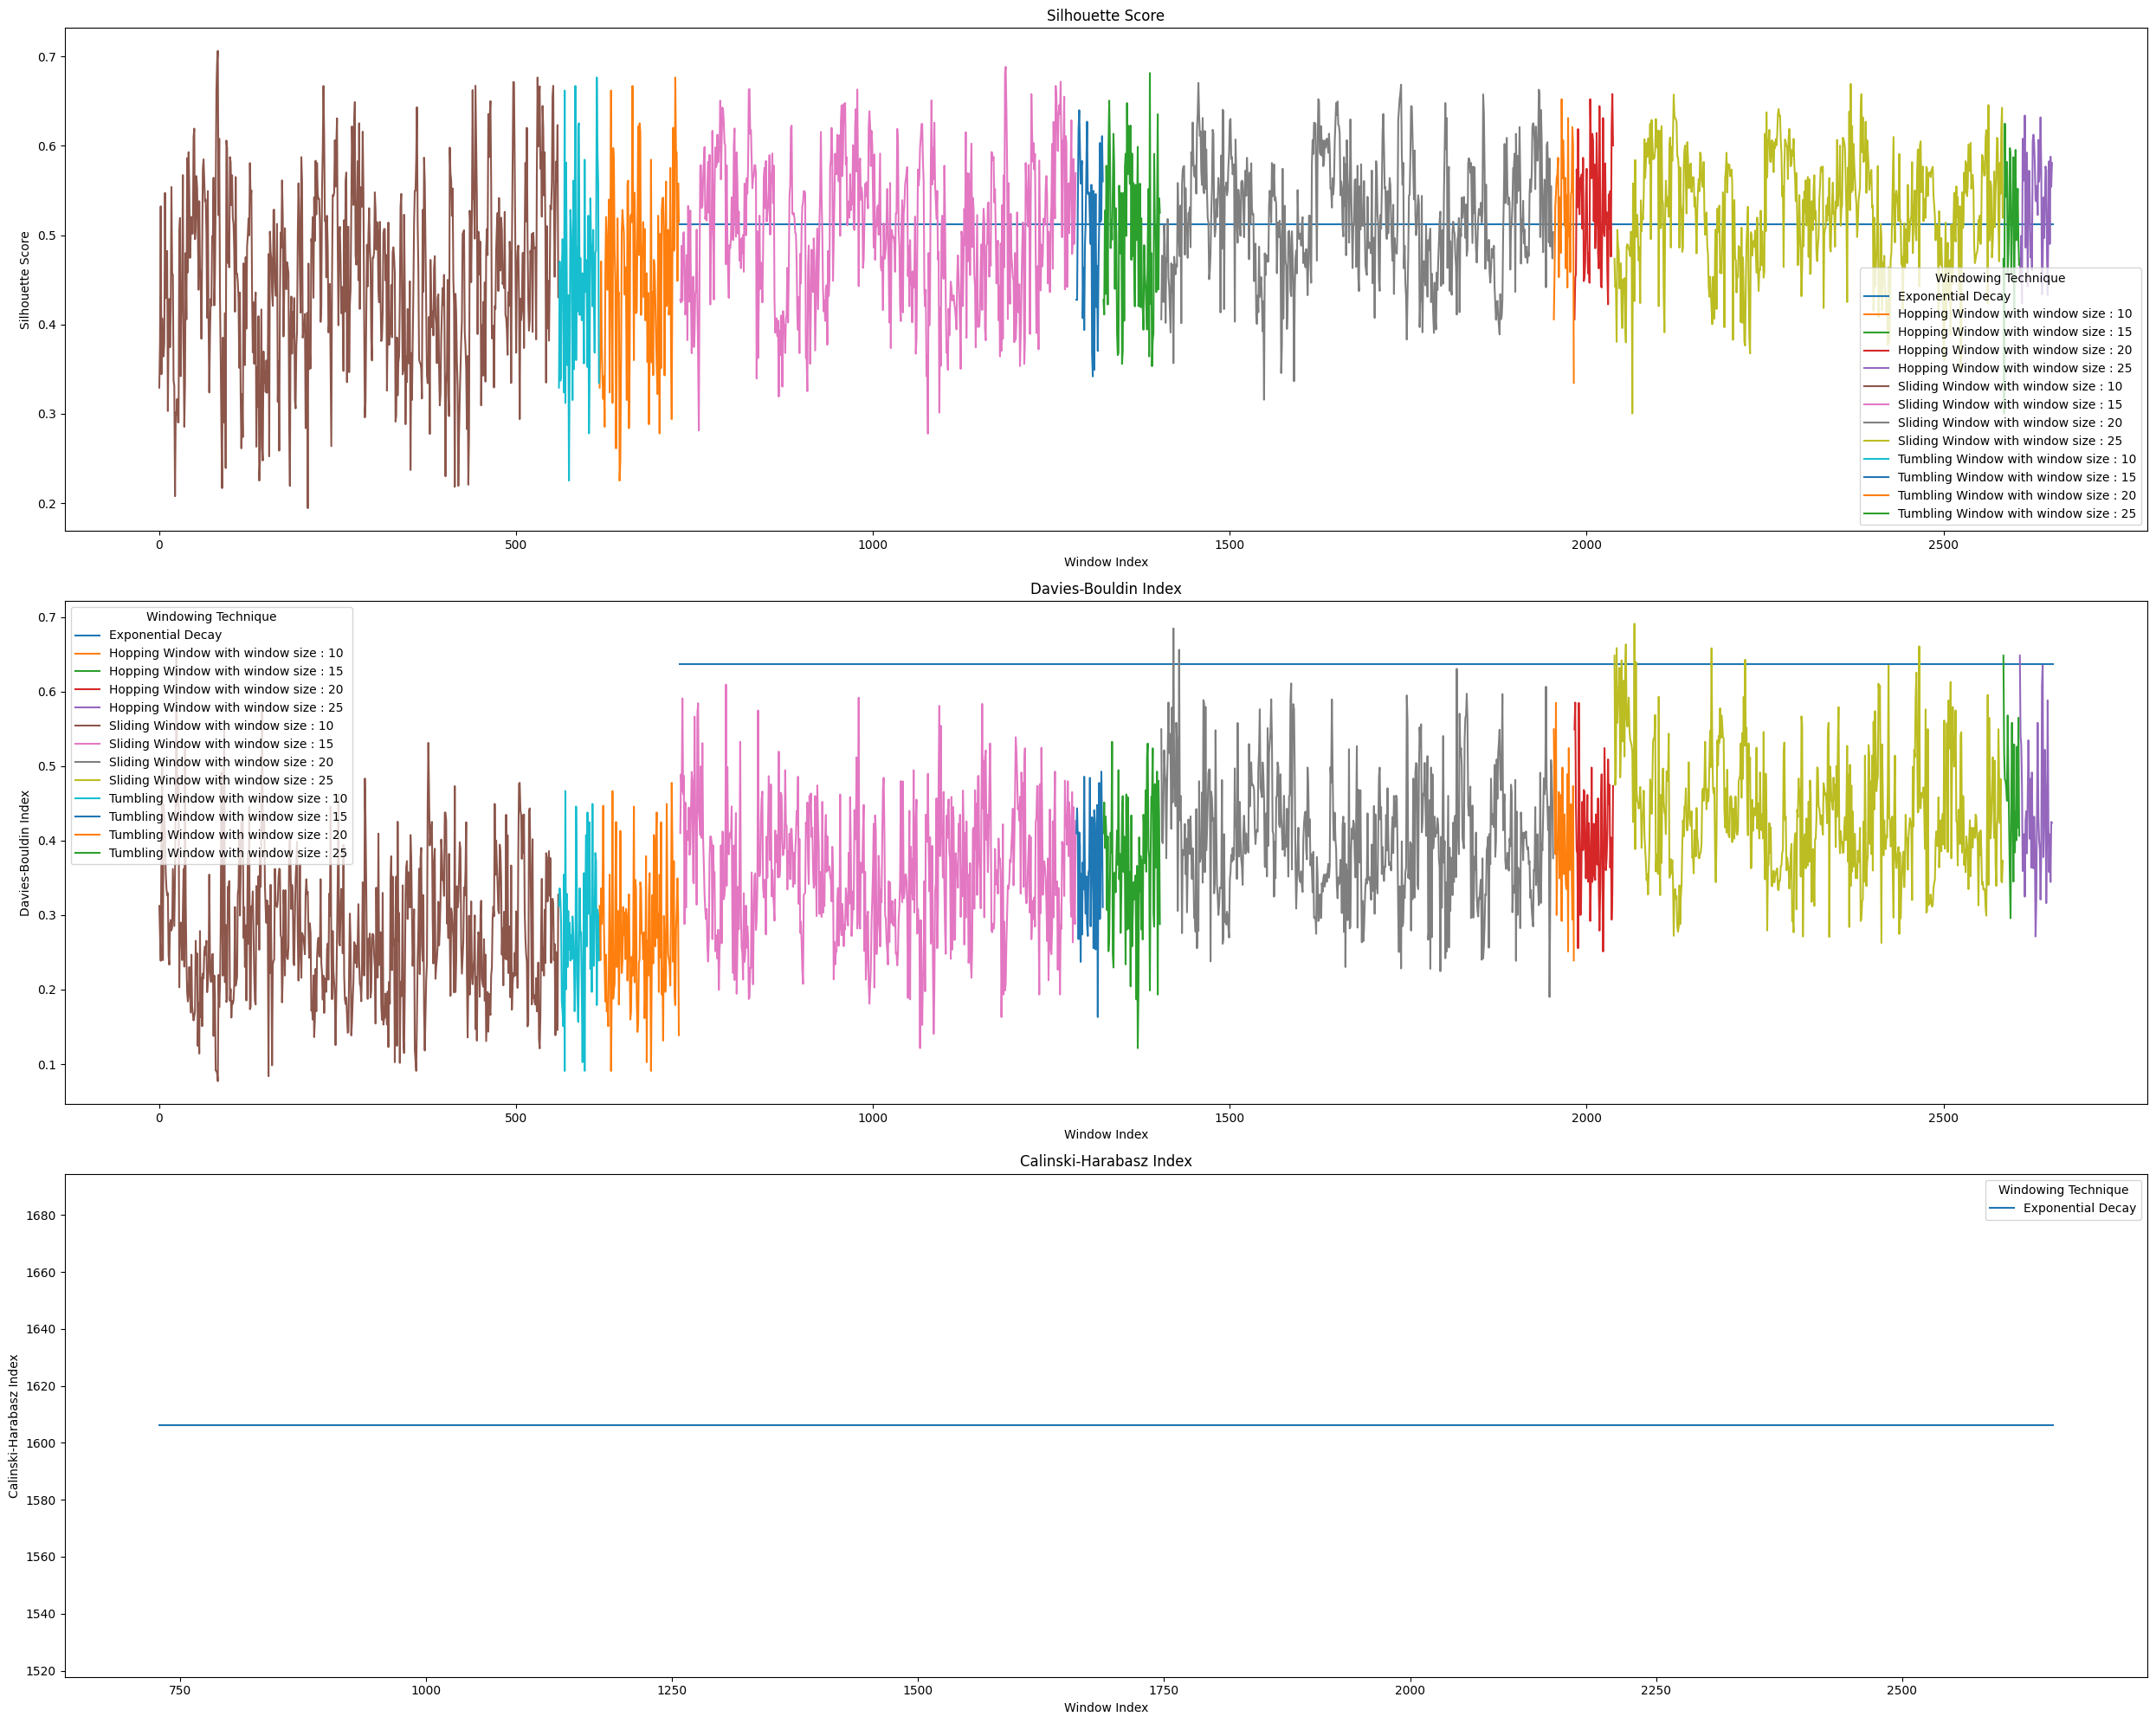

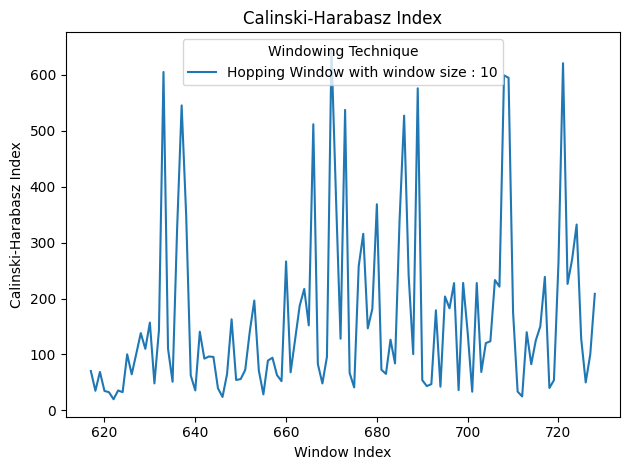

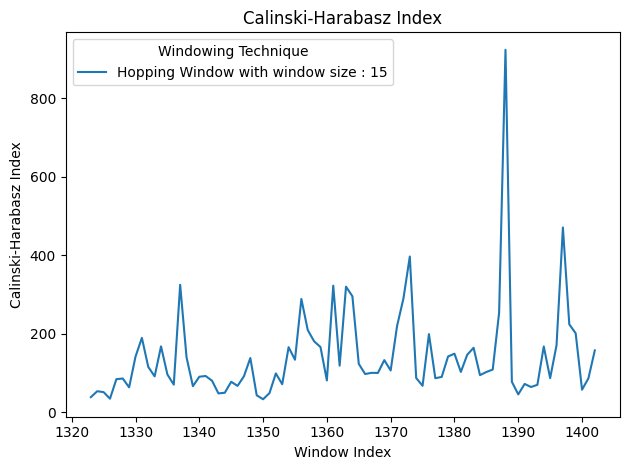

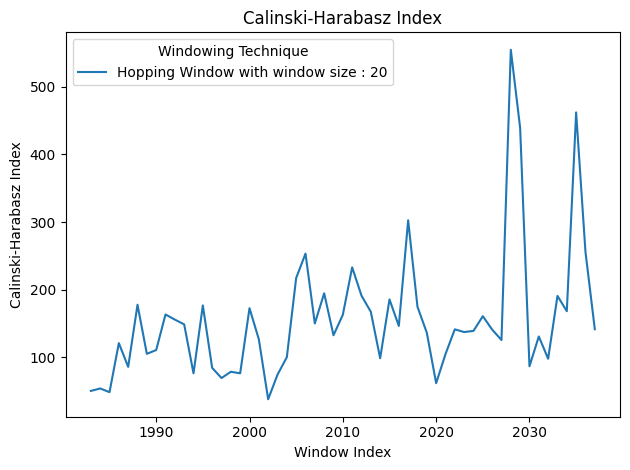

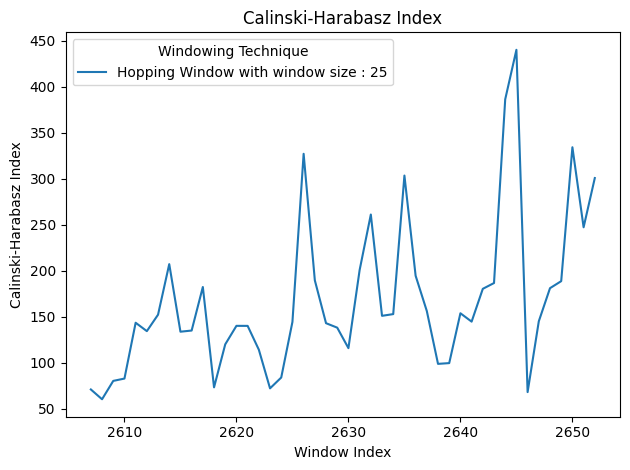

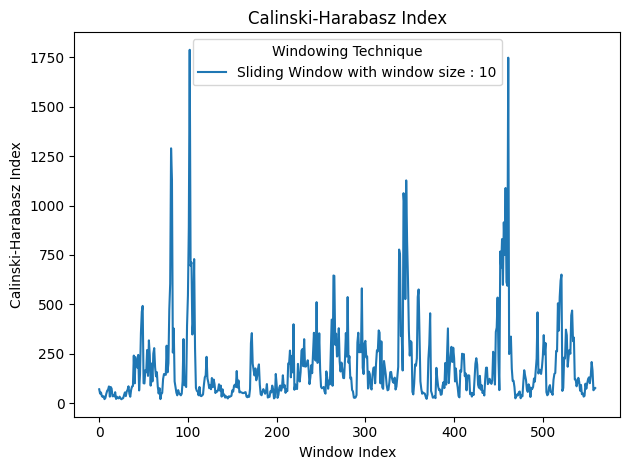

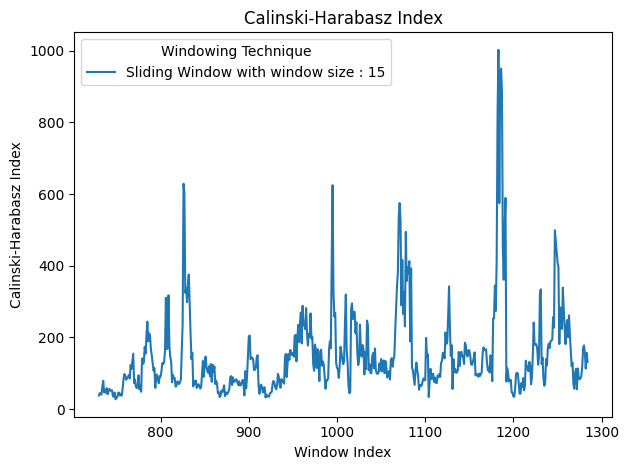

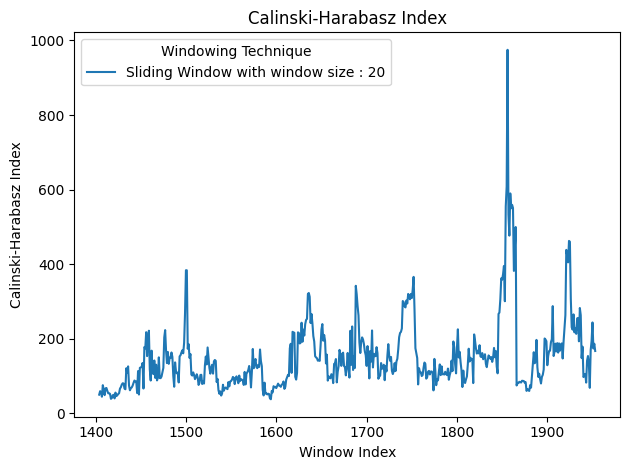

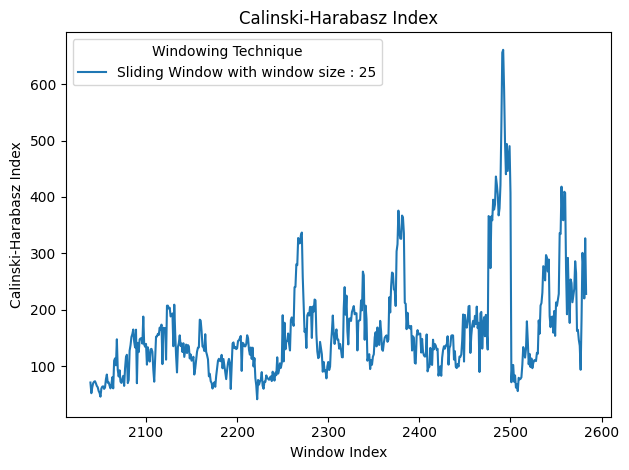

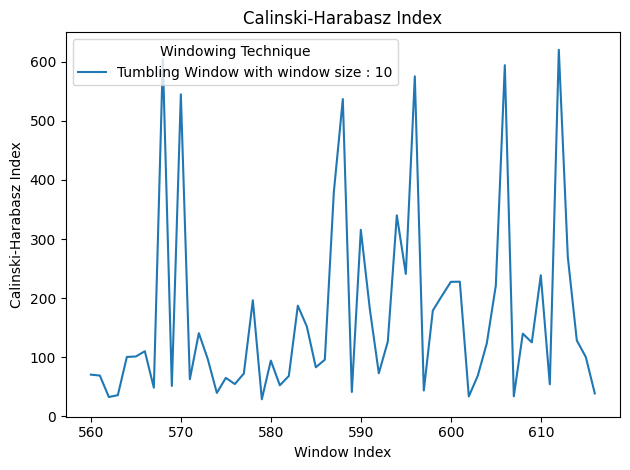

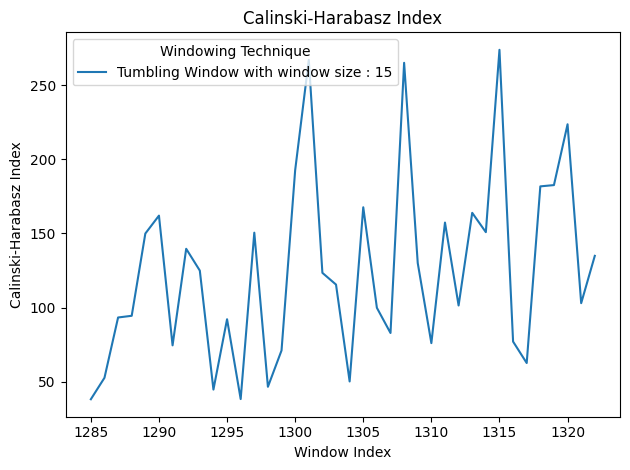

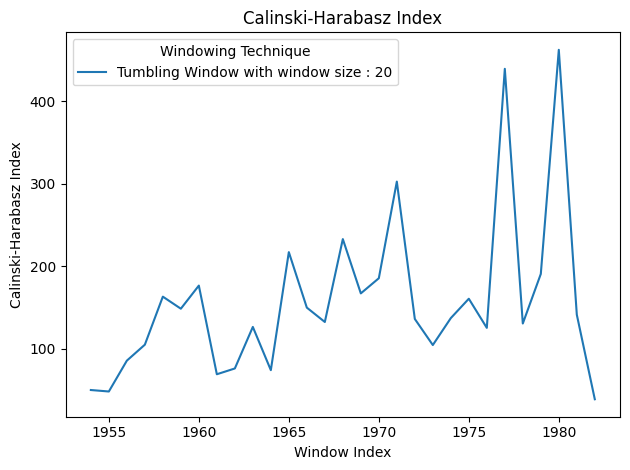

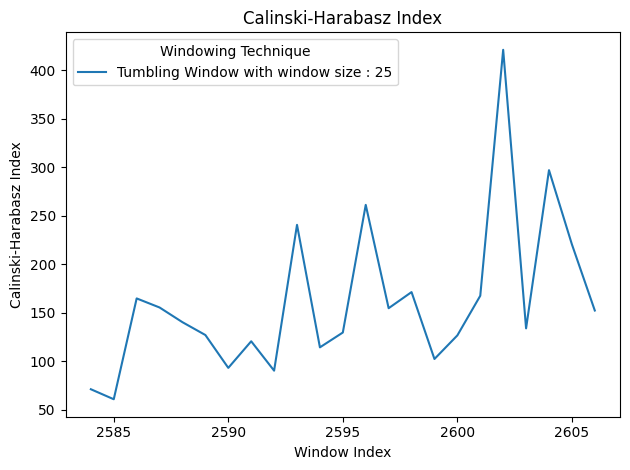

In [18]:
df = pd.DataFrame(clustering_metrics)
plot_clustering_metrics(df)